In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel
import matplotlib.patches as mpatches
import os
import pandas as pd
import pickle

## Make a list of SN

In [2]:
directory = os.fsencode("/root/partiiiproject/Archive")
supernovae_names = ["sn2006hb"]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".dat"):
        supernovae_names.append(filename[:-4])
        continue
    else:
        continue


## List of Dust laws

In [3]:
dust_laws = ('F99', 'F19', 'G23')
method = "sim" #"fit" or "sim"

## Set up data frame

In [4]:
df = pd.DataFrame(columns=dust_laws)
df = pd.DataFrame(df, index=supernovae_names)
print(df)
#df.to_csv("ChiSquared"+method+".csv")

          F99  F19  G23
sn2006hb  NaN  NaN  NaN
sn2006hb  NaN  NaN  NaN
sn2008fl  NaN  NaN  NaN
sn2007jg  NaN  NaN  NaN
sn2008R   NaN  NaN  NaN
...       ...  ...  ...
sn2007hj  NaN  NaN  NaN
sn2005ki  NaN  NaN  NaN
sn2007bc  NaN  NaN  NaN
sn2005iq  NaN  NaN  NaN
sn2008bq  NaN  NaN  NaN

[91 rows x 3 columns]


## Load W22 Model

In [5]:
filter_yaml = "/root/partiiiproject/bayesn-filters/bayesn-filters/filters.yaml"
model = SEDmodel(load_model='W22_model', filter_yaml = filter_yaml)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99


## Open  Existing Dataframe

In [6]:
df = pd.read_csv("ChiSquared"+method+".csv")
df = df.drop(['Unnamed: 0'], axis=1)
df.index = supernovae_names
print(df)

                   F99         F19           G23
sn2006hb  25203.101601         NaN  24731.056540
sn2006hb  25203.101601         NaN  24731.056540
sn2008fl    336.825466  328.461439    378.334341
sn2007jg     43.982658   57.898956     65.075437
sn2008R      38.130881  164.590138    281.429539
...                ...         ...           ...
sn2007hj           NaN         NaN           NaN
sn2005ki           NaN         NaN           NaN
sn2007bc           NaN         NaN           NaN
sn2005iq           NaN         NaN           NaN
sn2008bq           NaN         NaN           NaN

[91 rows x 3 columns]


## Loop through all SN - Method 1 (simulate light curves)

In [7]:
if method == "sim":

    progress = 1
    for supernova_name in supernovae_names[72:]:
        supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"
        meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
        lcdata = lcdata['OBS'].to_pandas()
        t_obs = lcdata['MJD'] - meta['SEARCH_PEAKMJD']
        bands = np.unique(lcdata['FLT'])
        z = meta['REDSHIFT_FINAL']
        ebv_mw = meta['MWEBV']
    
        for dust_law in dust_laws:
    
            try:
                sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
                sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"
            
                samplesSummary = pd.read_csv(sampleSummaryDir)
                samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])
            
                t_obs = np.unique(t_obs)
            except FileNotFoundError:
                continue
        
            with open(sampleChainsDir, 'rb') as file:
                chains = pickle.load(file)
            
            N=1
            fit_mu = np.mean(chains['mu'])
            fit_theta = np.mean(chains['theta'])
            fit_RV = np.mean(chains['RV'])
            fit_AV = np.mean(chains['AV'])
            fit_tmax = np.mean(chains['tmax'])
            fit_delM = np.mean(chains['delM'])
            fit_eps_inner = chains['eps']
            fit_eps_inner = np.reshape(fit_eps_inner, (4, 250, 9, 6), order='F')
            fit_eps = np.zeros((4, 250, 11, 6))
            fit_eps[:,:,1:-1,:] = fit_eps_inner
            fit_eps = fit_eps.mean(axis = 1)
            fit_eps = fit_eps.mean(axis = 0)
            fit_eps = np.reshape(fit_eps, (1 , 11, 6))
            try:
                sim = model.simulate_light_curve(t_obs, N, bands, mu=fit_mu, theta=fit_theta,  z=z, ebv_mw=ebv_mw, mag=False, write_to_files=False, AV=fit_AV, RV=fit_RV, redlaw=dust_law, tmax=fit_tmax, eps=fit_eps)
            except ValueError:
                continue
            flux, flux_err, params = sim
            flux = np.reshape(flux,(len(bands),len(t_obs)))
        
            chi_squared = np.zeros(len(lcdata))
            for i, entry in lcdata.iterrows():
                if entry.FLT == 'u_CSP':
                    continue
                index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
                index_band = np.where(bands == entry.FLT)
                Exp = flux[index_band, index_t_obs]
                Obs = entry.FLUXCAL
                ObsErr = entry.FLUXCALERR
                chi_squared_calc = ((Obs-Exp)**2)/(ObsErr**2)
                chi_squared_calc = ((Obs-Exp)**2)/Exp
                chi_squared[i] = chi_squared_calc[0]
                
            df.at[supernova_name, dust_law] = np.mean(chi_squared)
            progress = progress + 1
            print(str(progress)+ ' out of '+str(len(supernovae_names)*len(dust_laws)))
            df.to_csv("ChiSquared"+method+".csv")


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


2 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


3 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


4 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


5 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


6 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


7 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


8 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


9 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


10 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


11 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


12 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


13 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


14 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


15 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


16 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


17 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


18 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


19 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


20 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


21 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


22 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


23 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


24 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


25 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


26 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


27 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


28 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


29 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


30 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


31 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


32 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


33 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


34 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


35 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


36 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


37 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


38 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


39 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


40 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


41 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


42 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


43 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


44 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


45 out of 273
46 out of 273


/tmp/ipykernel_26153/3920134667.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_squared[i] = chi_squared_calc[0]


## Looping over all SN -  method 2 (fit from flux)

In [8]:
if method == "fit":

    progress = 0
    for supernova_name in supernovae_names[85:]:
        supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"
        meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
        lcdata = lcdata['OBS'].to_pandas()
        t_obs = lcdata['MJD'] - meta['SEARCH_PEAKMJD']
        t_obs = np.unique(t_obs)
        bands = np.unique(lcdata['FLT'])
        z = meta['REDSHIFT_FINAL']
        ebv_mw = meta['MWEBV']
    
        for dust_law in dust_laws:
    
            try:
                sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
                sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"
            
                samplesSummary = pd.read_csv(sampleSummaryDir)
                samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])
            
            except FileNotFoundError:
                continue
        
            with open(sampleChainsDir, 'rb') as file:
                chains = pickle.load(file)
            
            try:
                flux_grid = model.get_flux_from_chains(t_obs, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
                fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))
            except ValueError:
                continue
        
        
            chi_squared = np.zeros(len(lcdata))
            for i, entry in lcdata.iterrows():
                if entry.FLT == 'u_CSP':
                    continue
                index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
                index_band = np.where(bands == entry.FLT)
                Exp = fit[index_band, index_t_obs]
                Exp = Exp[0]
                Obs = entry.FLUXCAL
                ObsErr = entry.FLUXCALERR
                chi_squared_calc = ((Obs-Exp)**2)/(ObsErr**2)
                chi_squared[i] = chi_squared_calc[0]
                
            df.at[supernova_name, dust_law] = np.mean(chi_squared)
            progress = progress + 1
            print(str(progress)+ ' out of '+str(len(supernovae_names)*len(dust_laws)))
            df.to_csv("ChiSquared"+method+".csv")
    
    


## Plot as a bar chat of minimum Chi Squared value

/tmp/ipykernel_26153/3074086879.py:1: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  maxdf = df.idxmin(axis = 1)


sn2006hb    G23
sn2006hb    G23
sn2008fl    F19
sn2007jg    F99
sn2008R     F99
           ... 
sn2007hj    NaN
sn2005ki    NaN
sn2007bc    F99
sn2005iq    F99
sn2008bq    F19
Length: 91, dtype: object


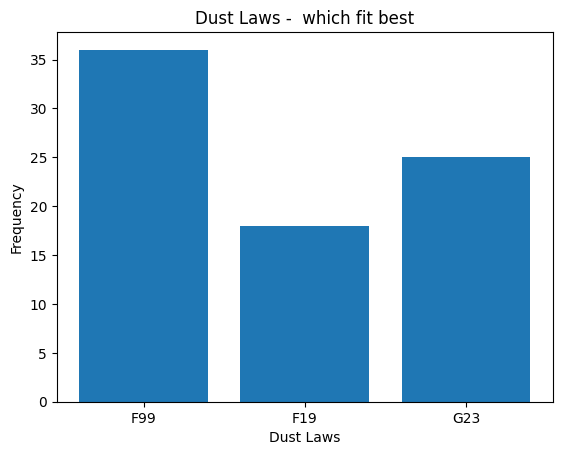

In [9]:
maxdf = df.idxmin(axis = 1)
print(maxdf)
frequency =  np.zeros(len(dust_laws))
for j in range(len(dust_laws)):
    frequency[j] = (maxdf == dust_laws[j]).sum()
plt.bar(dust_laws, frequency)
plt.title('Dust Laws -  which fit best')
plt.xlabel('Dust Laws')
plt.ylabel('Frequency')
plt.savefig("/root/partiiiproject/DustLawsGeneralGraphs/ChiSquaredBestDustLaw"+method+".png", bbox_inches='tight') 
plt.show()

## Plot as a graph as % difference between each Dust law relative to F99

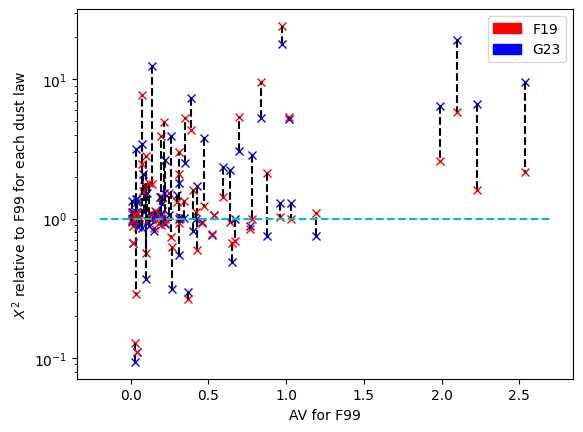

In [10]:
for supernova_name in supernovae_names:
    if supernova_name == "sn2006hb":
        continue
        
    supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"
    meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
    z = meta['REDSHIFT_FINAL']
    
    dust_law = "F99"
    sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"
    try:
        samplesSummary = pd.read_csv(sampleSummaryDir)
        samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])
        AV1 = samplesSummary.loc['AV[0]', 'mean']
        chi1 = df.at[supernova_name, dust_law]
    except FileNotFoundError:
        continue
    
    dust_law = "G23"
    chi2 = df.at[supernova_name, dust_law]
    plt.plot(AV1, chi2/chi1, f'bx', label=dust_law)
    

    dust_law = "F19"
    chi3 = df.at[supernova_name, dust_law]
    plt.plot(AV1, chi3/chi1, f'rx', label=dust_law)
    
    plt.plot([AV1, AV1], [chi2/chi1, chi3/chi1], 'k--')
    
plt.plot([-0.2,2.7], [1,1], 'c--')
plt.xlabel('AV for F99')
plt.ylabel(f"$X^2$ relative to F99 for each dust law")

red_patch = mpatches.Patch(color='red', label='F19')
blue_patch = mpatches.Patch(color='blue', label='G23')
plt.legend(handles=[red_patch, blue_patch])
plt.yscale("log")
plt.savefig("/root/partiiiproject/DustLawsGeneralGraphs/ChiSquaredPercentage"+method+".png", bbox_inches='tight') 
plt.show()